### 🚀 Introducción a Scrapy

Scrapy ([docs](https://docs.scrapy.org/en/latest/intro/tutorial.html)) es un framework en Python para construir spiders escalables y robustos para extracción de datos (web scraping). Está basado en Twisted (I/O asíncrona) y provee abstractions para: requests/response lifecycle, selección de datos, middlewares, pipelines y herramientas de extracción y export.

**Ventajas:**
- Arquitectura modular (middleware, pipelines)
- Concurrency y rendimiento (Twisted)
- Manejables para proyectos complejos (settings, items, spiders)
- Ecosistema: Splash, scrapy-playwright, scrapyd

### Arquitectura Interna (Alto Nivel)

Componentes principales:
- Engine: coordina el flujo (Scheduler, Downloader, Spiders)
- Scheduler: cola de requests, persistencia opcional (Redis)
- Downloader: gestiona peticiones HTTP, utiliza Downloader Middlewares
- Spiders: generan Requests y parsean Responses
- Item Pipeline: procesamiento final de items (limpieza, validación, persistencia)
- Middlewares: interceptan requests/responses
- Extensions: hooks para monitorización, stats

Diagrama conceptual (texto):
Spider -> Request -> Scheduler -> Downloader -> Response -> Spider -> Item -> Pipeline

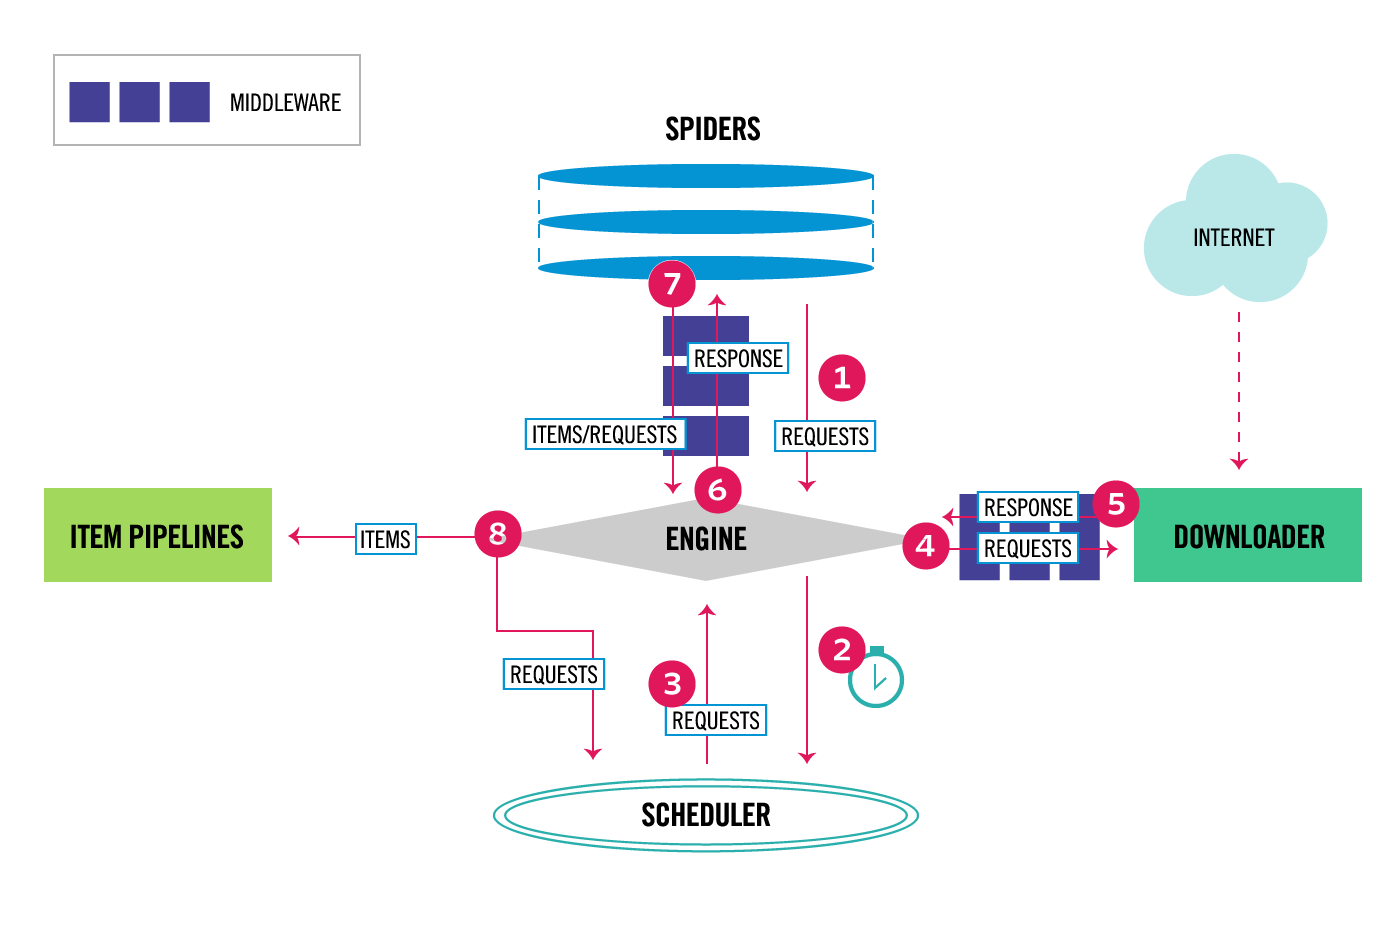

In [1]:
%pip install scrapy pandas pydantic openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import scrapy
from scrapy.crawler import CrawlerProcess


class UpNewsSpider(scrapy.Spider):
    name = "up_news"

    async def start(self):
        urls = [
            "https://www.up.edu.mx/tema/noticias/page/1/",
        ]
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)

    def parse(self, response):
        # get all news index
        for post in response.css("h2.wp-block-post-title"):
            link = post.css("a::attr(href)").get()

            self.logger.info(f"✨ News: {link}")

            yield response.follow(link, self._transform_news_post)

        # validate has next page
        next_page = response.css("span.page-numbers.current + a::attr(href)").get()
        if next_page is not None:
            # TODO: remove this when finish. Only for testing
            if "/6/" in next_page:
                self.logger.info(f"🐛 Ignore next page: {next_page}. Return")

                return

            self.logger.info(f"✨ Next page: {next_page}")
            yield response.follow(next_page, self.parse)

    def _transform_news_post(self, response):
        yield {
            "title": response.css("h1.wp-block-post-title::text").get(),
            "category": response.css("div.taxonomy-category a::text").get(),
            "date": response.css("div.wp-block-post-date time::text").get(),
            "image": response.css(
                "figure.wp-block-post-featured-image img::attr(src)"
            ).get(),
            "content": response.css(
                "div.wp-block-post-content, .entry-content::text"
            ).get(),
        }


In [ ]:
process = CrawlerProcess(
    settings={
        "FEEDS": {
            "news.json": {"format": "json"},
        },
        "LOG_ENABLED": True,
    }
)

process.crawl(UpNewsSpider)
process.start()

2025-12-09 21:25:37 [scrapy.utils.log] INFO: Scrapy 2.13.4 started (bot: scrapybot)
2025-12-09 21:25:37 [scrapy.utils.log] INFO: Versions:
{'lxml': '6.0.2',
 'libxml2': '2.11.9',
 'cssselect': '1.3.0',
 'parsel': '1.10.0',
 'w3lib': '2.3.1',
 'Twisted': '25.5.0',
 'Python': '3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 '
           '64 bit (AMD64)]',
 'pyOpenSSL': '25.3.0 (OpenSSL 3.5.4 30 Sep 2025)',
 'cryptography': '46.0.3',
 'Platform': 'Windows-11-10.0.26200-SP0'}
2025-12-09 21:25:37 [scrapy.addons] INFO: Enabled addons:
[]
2025-12-09 21:25:37 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.asyncioreactor.AsyncioSelectorReactor
2025-12-09 21:25:37 [scrapy.utils.log] DEBUG: Using asyncio event loop: asyncio.windows_events._WindowsSelectorEventLoop
2025-12-09 21:25:37 [scrapy.extensions.telnet] INFO: Telnet Password: 170d3edbc7afc0a6
2025-12-09 21:25:37 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.exte

RuntimeError: This event loop is already running

2025-12-09 21:25:38 [scrapy.core.engine] INFO: Spider opened
2025-12-09 21:25:38 [scrapy.extensions.logstats] INFO: Crawled 0 pages (at 0 pages/min), scraped 0 items (at 0 items/min)
2025-12-09 21:25:38 [scrapy.extensions.telnet] INFO: Telnet console listening on 127.0.0.1:6023
2025-12-09 21:25:58 [scrapy.downloadermiddlewares.redirect] DEBUG: Redirecting (301) to <GET https://www.up.edu.mx/tema/noticias/> from <GET https://www.up.edu.mx/tema/noticias/page/1/>
2025-12-09 21:26:18 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.up.edu.mx/tema/noticias/> (referer: None)
2025-12-09 21:26:18 [up_news] INFO: ✨ News: https://www.up.edu.mx/noticias/arte-cultura-y-difusion/la-up-lidera-la-innovacion-educativa-y-editorial-en-la-fil-guadalajara-2025/
2025-12-09 21:26:18 [up_news] INFO: ✨ News: https://www.up.edu.mx/noticias/arte-cultura-y-difusion/la-up-lidera-la-innovacion-educativa-y-editorial-en-la-fil-guadalajara-2025/
2025-12-09 21:26:18 [up_news] INFO: ✨ News: https://www.up.edu

: 